In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import factorial
import scipy.optimize
import scipy.interpolate
import sys
import functools
sys.path.append('../STRIDE')
from gfile_helpers import read_gfile, write_gfile, plot_gfile
import time as pytime

In [2]:
try:
#     raise
    import jax
    from jax import jit
    import jax.numpy as np
    from jax.config import config
    config.update("jax_enable_x64", True)
    x = np.linspace(0,5)
    y = np.exp(1)
    use_jax = True
    print('Using JAX')
    print(x.dtype)
except:
    import numpy as np
    def jit(*args,**kwargs):
        pass
    np.seterr(divide='ignore', invalid='ignore')
    use_jax = False
    print('JAX borked, using numpy')
    
    
if use_jax:
    def put(arr,inds,vals):
        """basically a way to do arr[inds] = vals in a way that plays nice with jit/autodiff"""
        return jax.ops.index_update(arr,inds,vals)
else:
    def put(arr,inds,vals):
        """basically a way to do arr[inds] = vals in a way that plays nice with jit/autodiff"""
        np.put(arr,inds,vals)
        return arr

    
    
def conditional_decorator(dec, condition, *args, **kwargs):
    """apply arbitrary decorator to a function if condition is met"""
    def decorator(func):
        if not condition:
            # Return the function unchanged, not decorated.
            return func
        return dec(func,*args,**kwargs)
    return decorator

Using JAX
float64


/home/fouriest/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8

In [4]:
def zern_radial(x,l,m):
    """Zernike radial basis function
    
    Args:
        x (array-like): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    y = np.zeros_like(x)
    lm_even = (l-m)%2 == 0
    m = np.abs(m)
    k = np.arange((l-m)/2+1).astype(np.float32)
    coeff = (-1)**k* factorial(l-k)/(factorial(k) * factorial((l+m)//2-k) * factorial((l-m)//2-k))
    rho = x[:,np.newaxis]**(l-2*k)
    y = np.sum(coeff*rho,axis=1)
    return y*lm_even
    
def zern_radial_r(x,l,m):
    """Zernike radial basis function, first derivative in r
    
    Args:
        x (array-like): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    y = np.zeros_like(x)
    lm_even = (l-m)%2 == 0
    m = np.abs(m)
    k = np.arange((l-m)/2+1).astype(np.float32)
    coeff = (l-2*k)*(-1)**k* factorial(l-k)/(factorial(k) * factorial((l+m)//2-k) * factorial((l-m)//2-k))
    rho = x[:,np.newaxis]**np.maximum(l-2*k-1,0)
    y = np.sum(coeff*rho,axis=1)

    return y*lm_even
    
def zern_radial_rr(x,l,m):
    """Zernike radial basis function, second radial derivative
    
    Args:
        x (array-like): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    y = np.zeros_like(x)
    lm_even = (l-m)%2 == 0
    m = np.abs(m)
    k = np.arange((l-m)/2+1).astype(np.float32)
    coeff = (l-2*k-1)*(l-2*k)*(-1)**k* factorial(l-k)/(factorial(k) * factorial((l+m)//2-k) * factorial((l-m)//2-k))
    rho = x[:,np.newaxis]**np.maximum(l-2*k-2,0)
    y = np.sum(coeff*rho,axis=1)
    
    return y*lm_even

def zern_azimuthal(theta,l,m):
    """Zernike azimuthal basis function
    
    Args:
        theta (array-like): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    m_pos = m >= 0
    m_neg = m < 0
    m = np.abs(m)
    y = m_pos*np.cos(m*theta) + m_neg*np.sin(m*theta)

    return y
    
def zern_azimuthal_v(theta,l,m):
    """Zernike azimuthal basis function, first azimuthal derivative
    
    Args:
        theta (array-like): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    m_pos = m >= 0
    m_neg = m < 0
    m = np.abs(m)
    y = m_pos*(-m*np.sin(m*theta)) + m_neg*(m*np.cos(m*theta))

    return y
    
def zern_azimuthal_vv(theta,l,m):
    """Zernike azimuthal basis function, second azimuthal derivative
    
    Args:
        theta (array-like): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    m_pos = m >= 0
    m_neg = m < 0
    m = np.abs(m)
    y = m_pos*(-m**2*np.cos(m*theta)) + m_neg*(-m**2*np.sin(m*theta))

    return y

def four_toroidal(zeta,n,NFP):
    """Toroidal Fourier basis function
    
    Args:
        zeta (array-like): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
    """
    n_pos = n >= 0
    n_neg = n < 0

    n = np.abs(n)
    y0 = n_pos*(np.cos(n*NFP*zeta)) + n_neg*(np.sin(n*NFP*zeta))
    
    return y0

def four_toroidal_z(zeta,n,NFP):
    """Toroidal Fourier basis function, first toroidal derivative
    
    Args:
        zeta (array-like): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
    """
    n_pos = n >= 0
    n_neg = n < 0
    n = np.abs(n)
    y1 = n_pos*(-n*NFP*np.sin(n*NFP*zeta)) + n_neg*(n*NFP*np.cos(n*NFP*zeta))
    
    return y1

def four_toroidal_zz(zeta,n,NFP):
    """Toroidal Fourier basis function, second toroidal derivative
    
    Args:
        zeta (array-like): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
    """
    n_pos = n >= 0
    n_neg = n < 0
    n = np.abs(n)
    y2 = n_pos*(-(n*NFP)**2*np.cos(n*NFP*zeta)) + n_neg*(-(n*NFP)**2*np.sin(n*NFP*zeta))
    
    return y2

radial_derivatives = {0: zern_radial,
                      1: zern_radial_r,
                      2: zern_radial_rr}
poloidal_derivatives = {0: zern_azimuthal,
                        1: zern_azimuthal_v,
                        2: zern_azimuthal_vv}
toroidal_derivatives = {0: four_toroidal,
                        1: four_toroidal_z,
                        2: four_toroidal_zz}

def zern(r,theta,l,m,dr,dtheta):
    """Zernike 2D basis function
    
    Args:
        r (array-like): radial coordinates to evaluate basis
        theta (array-like): azimuthal coordinates to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
        dr (int): order of radial derivative
        dtheta (int): order of azimuthal derivative
    """
    radial = radial_derivatives[dr](r,l,m)
    azimuthal = poloidal_derivatives[dtheta](theta,l,m)
    
    return radial*azimuthal    
        
def four(zeta,n,NFP,dz):
    """Toroidal Fourier basis function
    
    Args:
        zeta (array-like): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
        dz (int): order of toroidal derivative
    """
    return toroidal_derivatives[dz](zeta,n,NFP)
    
    
def F_mn(theta,phi,m,n,NFP):
    """Double Fourier series for boundary/lambda
    
    Args:
        theta (array-like): poloidal angle to evaluate basis
        phi (array-like): toroidal angle to evaluate basis
        m (int): poloidal mode number
        n (int): toroidal mode number
        NFP (int): number of field periods
    """
    m_pos = m >= 0
    m_neg = m < 0
    n_pos = n >= 0
    n_neg = n < 0
    m = np.abs(m)
    n = np.abs(n)
    m_term = m_pos*np.cos(m*theta) + m_neg*np.sin(m*theta)
    n_term = n_pos*np.cos(n*NFP*phi) + n_neg*np.sin(n*NFP*phi)

    return m_term*n_term
        
def fourzern(r,theta,zeta,l,m,n,NFP,dr,dv,dz):
    """Combined 3D Fourier-Zernike basis function
    
    Args:
        r (array-like): radial coordinates
        theta (array-like): poloidal coordinates
        zeta (array-like): toroidal coordinates
        l (int): radial mode number
        m (int): poloidal mode number
        n (int): toroidal mode number
        NFP (int): number of field periods
        dr (int): order of radial derivative
        dv (int): order of poloidal derivative
        dz (int): order of toroidal derivative
    """
    return zern(r,theta,l,m,dr,dv)*four(zeta,n,NFP,dz)

if use_jax:
    F_mn = jax.jit(F_mn, static_argnums=(2,3,4))
    fourzern = jax.jit(fourzern, static_argnums=(3,4,5,6,7,8,9))
    zern = jax.jit(zern, static_argnums=(2,3,4,5))
    four = jax.jit(four, static_argnums=(1,2,3))

In [5]:
class ZernikeTransform():
    """Zernike Transform (really a Fourier-Zernike, but whatever)
    
    Args:
        nodes (array-like): nodes where basis functions are evaluated
        M (int): maximum poloidal mode number
        N (int): maximum toroidal mode number
        NFP (int): number of field periods    
    """
    def __init__(self,nodes, M,N,NFP):
        num_lm_modes = (M+1)**2
        num_four = 2*N+1
        # array of which l,m,n is at which column of the interpolation matrix
        self.idx = np.array([(*fringe_to_lm(i),n) for i in range(num_lm_modes) for n in range(num_four)])
        # array of which r,v,z is at which row of the interpolation matrix
        self.nodes = nodes
        self.M = M
        self.N = N
        self.NFP = NFP
        self.matrices = {i:{j:{k:np.stack([fourzern(nodes[0],nodes[1],nodes[2],
                                               *fringe_to_lm(lm),n-N,NFP,i,j,k) 
                                           for lm in range(num_lm_modes) for n in range(num_four)]).T 
                                           for k in range(3)} for j in range(3)} for i in range(3)}
        
    @conditional_decorator(functools.partial(jit,static_argnums=(0,2,3,4)), use_jax)    
    def transform(self,c,dr,dv,dz):
        """Transform from spectral domain to physical
        
        Args:
            c (array-like): spectral coefficients, indexed as (lm,n) flattened in row major order
            dr (int): order of radial derivative
            dv (int): order of poloidal derivative
            dz (int): order of toroidal derivative
        """
        return np.matmul(self.matrices[dr][dv][dz],c)

    @conditional_decorator(functools.partial(jit,static_argnums=(0,2)), use_jax)    
    def fit(self,x,rcond=1e-1):
        """Transform from physical domain to spectral
        
        Args:
            x (array-like): values in real space at coordinates specified by self.nodes
            rcond (float): relative cutoff for singular values in least squares fit        
        """
        return np.linalg.lstsq(self.matrices[0][0][0],x,rcond=rcond)[0]
        

In [6]:
def zernike_norm(l, m):
    """Norm of a Zernike polynomial with l, m indexing.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    return np.sqrt((2 * (l + 1)) / (1 + np.kronecker(m, 0)))

def lm_to_fringe(l, m):
    """Convert (l,m) two term index to Fringe index.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    term1 = (1 + (l + np.abs(m))/2)**2
    term2 = 2 * np.abs(m)
    term3 = (1 + np.sign(m)) / 2
    return int(term1 - term2 - term3)  

def fringe_to_lm(idx):
    """Convert Fringe Z to (l, m) two-term index.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    idx += 1 # shift 0 base to 1 base
    m_l = 2 * (np.ceil(np.sqrt(idx)) - 1)  # sum of n+m
    g_s = (m_l / 2)**2 + 1  # start of each group of equal n+m given as idx index
    l = m_l / 2 + np.floor((idx - g_s) / 2)
    m = (m_l - l) * (1 - np.mod(idx-g_s, 2) * 2)
    return int(l), int(m)

def lm_to_ansi_j(l, m):
    """Convert (n,m) two term index to ANSI single term index.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    return int((l * (l + 2) + m) / 2)


def ansi_j_to_lm(idx):
    """Convert ANSI single term to (n,m) two-term index.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    l = int(np.ceil((-3 + np.sqrt(9 + 8*idx))/2))
    m = 2 * idx - l * (l + 2)
    return l, m

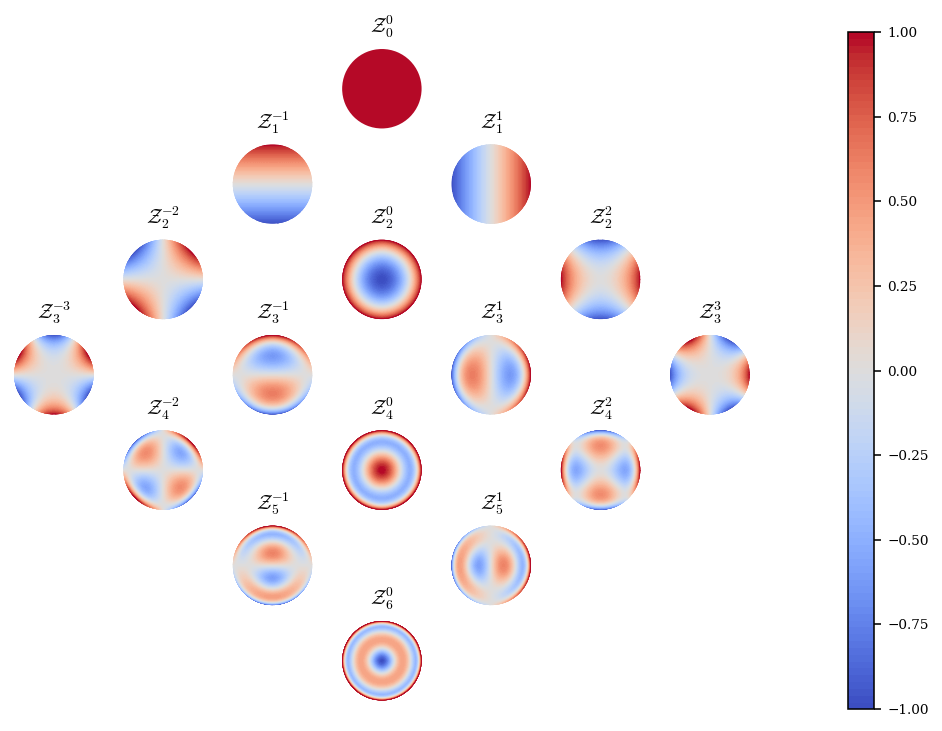

In [7]:
fig = plt.figure(figsize=(9,6))

mmax = 3
npts = 100
# nlm = (mmax+1)*(mmax+2)//2
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
levels = np.linspace(-1,1,npts)
lmax = np.max(lm[:,0])
ax = {i:{} for i in range(lmax+1)}
gs = matplotlib.gridspec.GridSpec(lmax+1, 2*(mmax+1)) 
for l,m in lm:
    r = np.linspace(0,1,npts)
    v = np.linspace(0,2*np.pi,npts)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    Z = zern(rr.flatten(),vv.flatten(),l,m,0,0).reshape((npts,npts))
    
    ax[l][m] = plt.subplot(gs[l,m+mmax:m+mmax+2],projection='polar')
    ax[l][m].set_title(r'$\mathcal{Z}_{' + str(l) + '}^{' + str(m) + '}$')
    ax[l][m].axis('off')
    im = ax[l][m].contourf(v,r,Z,levels=levels,cmap='coolwarm')
#     ax[l][m].plot(v,np.ones_like(v),lw=2,c='k')

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.subplots_adjust(right=.8)
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_ticks(np.linspace(-1, 1, 9))

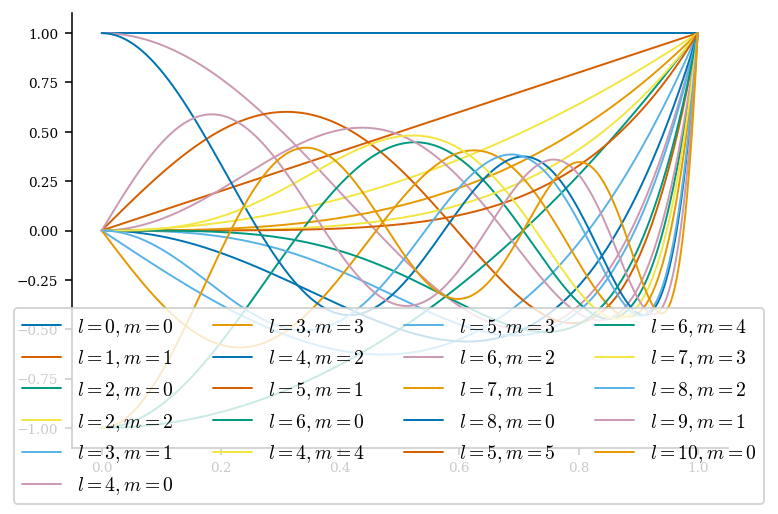

In [8]:
fig, ax = plt.subplots()

mmax = 5
npts = 1000
# nlm = (mmax+1)*(mmax+2)//2
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
r = np.linspace(0,1,npts)

for l,m in lm:
    if (l-m)%2 == 0 and m>=0:
        ax.plot(r,zern_radial(r,l,m),lw=1,label='$l={},m={}$'.format(l,m))
fig.legend(ncol=4, loc='lower center',)

In [9]:
def get_initial_guess_scale_bdry(bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP,nr=20,rcond=1e-1, return_rvz=False):
    """Generate initial guess by scaling boundary shape
    
    Args:
        bdryR (array-like): R coordinates of boundary
        bdryZ (array-like): Z coordinates of boundary
        bdry_theta (array-like): poloidal coordinates where bdryR,bdryZ are given
        bdry_phi (array-like): toroidal coordinates where bdryR,bdryZ are given
        M (int): maximum poloidal mode number
        N (int): maximum toroidal mode number
        NFP (int): number of field periods
        nr (int): number of radial points to use when generating guess
        rcond (float): relative limit on singular values for least squares fit to Zernike basis
        return_rvz (bool): whether to also return the grid used to generate the initial guess
        
    Returns:
        cR (array-like): Fourier-Zernike coefficients for R, indexed as (lm,n) flattened in row major order
        cZ (array-like): Fourier-Zernike coefficients for Z, indexed as (lm,n) flattened in row major order
        cL (array-like): double Fourier series coefficients for lambda, indexed as (m,n) flattened in row major order
        Rinit (array-like): R coordinates of initial flux surface guess
        Zinit (array-like): Z coordinates of initial flux surface guess
        
        if return_rvz:
        rr,vv,zz (array-like): grid used to generate initial guess
    """
    
    
    r = np.linspace(1e-2,1,nr)
    rr,tt = np.meshgrid(r,bdry_theta,indexing='ij')
    rr,pp = np.meshgrid(r,bdry_phi,indexing='ij')
    rr = rr.flatten()
    tt = tt.flatten()
    pp = pp.flatten()
    vv = np.pi - tt
    zz = -pp

    zernt = ZernikeTransform([rr,vv,zz],M,N,NFP)
    R0_est = (np.max(bdryR) + np.min(bdryR))/2
    Z0_est = (np.max(bdryZ) + np.min(bdryZ))/2

    Rinit = (r[:,np.newaxis]*(bdryR[np.newaxis,:]-R0_est) + R0_est).flatten()
    Zinit = (r[:,np.newaxis]*(bdryZ[np.newaxis,:]-Z0_est) + Z0_est).flatten()

    cL = np.zeros((2*M+1)*(2*N+1))
    cR = zernt.fit(Rinit,rcond).flatten()
    cZ = zernt.fit(Zinit,rcond).flatten()
    if return_rvz:
        return cR, cZ, cL, Rinit, Zinit, rr, vv, zz
    else:
        return cR, cZ, cL, Rinit, Zinit

In [10]:
def compute_bc_err_RZ(cR,cZ,cL,bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP):
    """Compute boundary error at discrete points
    
    Args:
        cR (array-like): Fourier-Zernike coefficients of R
        cZ (array-like): Fourier-Zernike coefficients of Z
        cL (array-like): double Fourier coefficients of lambda
        bdryR (array-like): R values of boundary shape
        bdryZ (array-like): Z values of boundary shape
        bdry_theta (array-like): real space poloidal coordinates where boundary is specified
        bdry_phi (array-like): real space toroidal coordinates where boundary is specified
        M (int): maximum poloidal mode number
        N (int): maximum toroidal mode number
        NFP (int): number of field periods   
        
    Returns:
        errR (array-like): vector of R errors in boundary position at specified points
        errZ (array-like): vector of Z errors in boundary position at specified points
        errL (float): sum of lambda_mn
    """
    num_lm_modes = (M+1)**2
    num_four = 2*N+1    
    num_lambda_m = 2*M+1
    num_lambda_n = 2*N+1
    # compute lambda, theres probably a faster vectorized way to do this
    
    # vartheta(theta,phi) = pi - theta + lambda(theta,phi)
    L = np.zeros_like(bdry_theta)
    errL = 0
    for i in range(num_lambda_m):
        for j in range(num_lambda_n):
            m = -M + i
            n = -N + j
            k = i*num_lambda_n + j
            mask = m >= 0 and n >=0
            errL = errL + mask*cL[k]
            L = L + cL[k]*F_mn(bdry_theta,bdry_phi,m,n,NFP)

    # find values of R,Z at pts specified
    rho = np.ones_like(bdry_theta)
    vartheta = np.pi - bdry_theta + L
    zeta = -bdry_phi
    bdry_interp = np.stack([fourzern(rho,vartheta,zeta,*fringe_to_lm(i),n-N,NFP,0,0,0) for i in range(num_lm_modes) 
                            for n in range(num_four)]).T
    R = np.matmul(bdry_interp,cR).flatten()
    Z = np.matmul(bdry_interp,cZ).flatten()

    # compute errors
    errR = R-bdryR
    errZ = Z-bdryZ
    return errR,errZ,errL

In [11]:
def compute_coordinate_derivatives(cR,cZ,zernt):
    """Converts from spectral to real space and evaluates derivatives of R,Z wrt to SFL coords
    
    Args:
        cR (array-like): spectral coefficients of R
        cZ (array-like): spectral coefficients of Z
        zernt (ZernikeTransform): object with transform method to go from spectral to physical space with derivatives
    
    Returns:
        coordinate_derivatives (dict): dictionary of arrays of coordinate derivatives evaluated at node locations
    """
    
    # notation: X_y means derivative of X wrt y
    coordinate_derivatives = {}
    coordinate_derivatives['R'] = zernt.transform(cR,0,0,0)
    coordinate_derivatives['Z'] = zernt.transform(cZ,0,0,0)
    coordinate_derivatives['0'] = np.zeros_like(coordinate_derivatives['R'])
    
    coordinate_derivatives['R_r'] = zernt.transform(cR,1,0,0)
    coordinate_derivatives['Z_r'] = zernt.transform(cZ,1,0,0)
    coordinate_derivatives['R_v'] = zernt.transform(cR,0,1,0)
    coordinate_derivatives['Z_v'] = zernt.transform(cZ,0,1,0)
    coordinate_derivatives['R_z'] = zernt.transform(cR,0,0,1)
    coordinate_derivatives['Z_z'] = zernt.transform(cZ,0,0,1)

    coordinate_derivatives['R_rr'] = zernt.transform(cR,2,0,0)
    coordinate_derivatives['Z_rr'] = zernt.transform(cZ,2,0,0)
    coordinate_derivatives['R_rv'] = zernt.transform(cR,1,1,0)
    coordinate_derivatives['Z_rv'] = zernt.transform(cZ,1,1,0)
    coordinate_derivatives['R_rz'] = zernt.transform(cR,1,0,1)
    coordinate_derivatives['Z_rz'] = zernt.transform(cZ,1,0,1)

    coordinate_derivatives['R_vr'] = zernt.transform(cR,1,1,0)
    coordinate_derivatives['Z_vr'] = zernt.transform(cZ,1,1,0)
    coordinate_derivatives['R_vv'] = zernt.transform(cR,0,2,0)
    coordinate_derivatives['Z_vv'] = zernt.transform(cZ,0,2,0)
    coordinate_derivatives['R_vz'] = zernt.transform(cR,0,1,1)
    coordinate_derivatives['Z_vz'] = zernt.transform(cZ,0,1,1)

    coordinate_derivatives['R_zr'] = zernt.transform(cR,1,0,1)
    coordinate_derivatives['Z_zr'] = zernt.transform(cZ,1,0,1)
    coordinate_derivatives['R_zv'] = zernt.transform(cR,0,1,1)
    coordinate_derivatives['Z_zv'] = zernt.transform(cZ,0,1,1)
    coordinate_derivatives['R_zz'] = zernt.transform(cR,0,0,2)
    coordinate_derivatives['Z_zz'] = zernt.transform(cZ,0,0,2)

    coordinate_derivatives['R_rrv'] = zernt.transform(cR,2,1,0)
    coordinate_derivatives['Z_rrv'] = zernt.transform(cZ,2,1,0)
    coordinate_derivatives['R_rvv'] = zernt.transform(cR,1,2,0)
    coordinate_derivatives['Z_rvv'] = zernt.transform(cZ,1,2,0)
    coordinate_derivatives['R_zrv'] = zernt.transform(cR,1,1,1)
    coordinate_derivatives['Z_zrv'] = zernt.transform(cZ,1,1,1)

    coordinate_derivatives['R_rrvv'] = zernt.transform(cR,2,2,0)
    coordinate_derivatives['Z_rrvv'] = zernt.transform(cZ,2,2,0)
    
    return coordinate_derivatives

In [12]:
def compute_covariant_basis_vectors(coordinate_derivatives):
    """Computes covariant basis vectors at grid points
    
    Args:
        coordinate_derivatives (dict): dictionary of arrays of the coordinate derivatives at each node
        
    Returns:
        covariant_basis (dict): dictionary of arrays of covariant basis vectors and derivatives at each node
    """
    # notation: first subscript is direction of unit vector, others denote partial derivatives
    # eg, e_rv is the v derivative of the covariant basis vector in the r direction
    cov_basis = {}
    cov_basis['e_r'] = np.array([coordinate_derivatives['R_r'],coordinate_derivatives['0'],coordinate_derivatives['Z_r']])
    cov_basis['e_v'] = np.array([coordinate_derivatives['R_v'],coordinate_derivatives['0'],coordinate_derivatives['Z_v']])
    cov_basis['e_z'] = np.array([coordinate_derivatives['R_z'],-coordinate_derivatives['R'],coordinate_derivatives['Z_z']])

    cov_basis['e_rr'] = np.array([coordinate_derivatives['R_rr'],coordinate_derivatives['0'],coordinate_derivatives['Z_rr']])
    cov_basis['e_rv'] = np.array([coordinate_derivatives['R_rv'],coordinate_derivatives['0'],coordinate_derivatives['Z_rv']])
    cov_basis['e_rz'] = np.array([coordinate_derivatives['R_rz'],coordinate_derivatives['0'],coordinate_derivatives['Z_rz']])

    cov_basis['e_vr'] = np.array([coordinate_derivatives['R_vr'],coordinate_derivatives['0'],coordinate_derivatives['Z_vr']])
    cov_basis['e_vv'] = np.array([coordinate_derivatives['R_vv'],coordinate_derivatives['0'],coordinate_derivatives['Z_vv']])
    cov_basis['e_vz'] = np.array([coordinate_derivatives['R_vz'],coordinate_derivatives['0'],coordinate_derivatives['Z_vz']])

    cov_basis['e_zr'] = np.array([coordinate_derivatives['R_zr'],-coordinate_derivatives['R_r'],coordinate_derivatives['Z_zr']])
    cov_basis['e_zv'] = np.array([coordinate_derivatives['R_zv'],-coordinate_derivatives['R_v'],coordinate_derivatives['Z_zv']])
    cov_basis['e_zz'] = np.array([coordinate_derivatives['R_zz'],-coordinate_derivatives['R_z'],coordinate_derivatives['Z_zz']])

    cov_basis['e_rvv'] = np.array([coordinate_derivatives['R_rvv'],coordinate_derivatives['0'],coordinate_derivatives['Z_rvv']])
    cov_basis['e_rvz'] = np.array([coordinate_derivatives['R_zrv'],coordinate_derivatives['0'],coordinate_derivatives['Z_zrv']])
    cov_basis['e_zrv'] = np.array([coordinate_derivatives['R_zrv'],-coordinate_derivatives['R_rv'],coordinate_derivatives['Z_zrv']])
    
    return cov_basis

In [13]:
def compute_jacobian(coordinate_derivatives,covariant_basis_vectors):
    """Computes coordinate jacobian and derivatives
    
    Args:
        coordinate_derivatives (dict): dictionary of arrays of coordinate derivatives evaluated at node locations
        covariant_basis_vectors (dict): dictionary of arrays of covariant basis vectors and derivatives at each node 
        
    Returns:
        jacobian (dict): dictionary of arrays of coordinate jacobian and partial derivatives
    """
    # notation: subscripts denote partial derivatives
    jacobian = {}    
    jacobian['g'] = dot(covariant_basis_vectors['e_r'] , cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_z'],0),0)

    jacobian['g_r'] = dot(covariant_basis_vectors['e_rr'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_rv'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_zr'],0),0)
    jacobian['g_v'] = dot(covariant_basis_vectors['e_rv'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_vv'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_zv'],0),0)
    jacobian['g_z'] = dot(covariant_basis_vectors['e_rz'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_vz'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_zz'],0),0)
    # need these later for rho=0
    jacobian['g_rr']  = coordinate_derivatives['R']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rrv'] 
                                                     - coordinate_derivatives['Z_r']*coordinate_derivatives['R_rrv']
                                                     + 2*coordinate_derivatives['R_rr']*coordinate_derivatives['Z_rv']
                                                     - 2*coordinate_derivatives['R_rv']*coordinate_derivatives['Z_rr']) \
                                        + 2*coordinate_derivatives['R_r']*(coordinate_derivatives['Z_rv']*coordinate_derivatives['R_r']
                                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r'])
    jacobian['g_rv']  = coordinate_derivatives['R']*(coordinate_derivatives['Z_rvv']*coordinate_derivatives['R_r']
                                                     - coordinate_derivatives['R_rvv']*coordinate_derivatives['Z_r'])
    jacobian['g_zr']  = coordinate_derivatives['R_z']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rv'] 
                                                       - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r']) \
                            + coordinate_derivatives['R']*(coordinate_derivatives['R_zr']*coordinate_derivatives['Z_rv'] 
                                                           + coordinate_derivatives['R_r']*coordinate_derivatives['Z_zrv']
                                                           - coordinate_derivatives['R_zrv']*coordinate_derivatives['Z_r']
                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_zr'])
    jacobian['g_rrv'] = 2*coordinate_derivatives['R_rv']*(coordinate_derivatives['Z_rv']*coordinate_derivatives['R_r']
                                                          - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r']) \
                            + 2*coordinate_derivatives['R_r']*(coordinate_derivatives['Z_rvv']*coordinate_derivatives['R_r']
                                                               - coordinate_derivatives['R_rvv']*coordinate_derivatives['Z_r']) \
                            + coordinate_derivatives['R']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rrvv']
                                                           - coordinate_derivatives['Z_r']*coordinate_derivatives['R_rrvv']
                                                           + 2*coordinate_derivatives['R_rr']*coordinate_derivatives['Z_rvv']
                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_rrv']
                                                           - 2*coordinate_derivatives['Z_rr']*coordinate_derivatives['R_rvv']
                                                           + coordinate_derivatives['Z_rv']*coordinate_derivatives['R_rrv'])
    for key, val in jacobian.items():
        jacobian[key] = val.flatten()
    
    return jacobian

In [14]:
def compute_B_field(Psi_total, jacobian, nodes, axn, covariant_basis_vectors, iotafun_params):
    """Computes magnetic field at node locations
    
    Args:
        Psi_total (float): total toroidal flux within LCFS
        jacobian (dict): dictionary of arrays of coordinate jacobian and partial derivatives
        nodes (array-like): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis
        covariant_basis_vectors (dict): dictionary of arrays of covariant basis vectors and derivatives at each node 
        iotafun_params (array-like): parameters to pass to rotational transform function   
    Return:
        B_field (dict): dictionary of values of magnetic field and derivatives
    """
    # notation: 1 letter subscripts denote derivatives, eg psi_rr = d^2 psi/dr^2
    # word sub or superscripts denote co and contravariant components of the field
    r = nodes[0]   
    iota = iotafun(r,0, iotafun_params)
    iotar = iotafun(r,1, iotafun_params)
    
    B_field = {}
    # B field
    B_field['psi'] = Psi_total*r**2 # could instead make Psi(r) an arbitrary function?
    B_field['psi_r']  = 2*Psi_total*r
    B_field['psi_rr'] = 2*Psi_total*np.ones_like(r)
    B_field['B^zeta'] = B_field['psi_r'] / (2*np.pi*jacobian['g'])
    B_field['B^theta'] = iota * B_field['B^zeta']

    # B^{zeta} derivatives
    B_field['B^zeta_r'] = B_field['psi_rr'] / (2*np.pi*jacobian['g']) - (B_field['psi_r']*jacobian['g_r']) / (2*np.pi*jacobian['g']**2)
    B_field['B^zeta_v'] = - (B_field['psi_r']*jacobian['g_v']) / (2*np.pi*jacobian['g']**2)
    B_field['B^zeta_z'] = - (B_field['psi_r']*jacobian['g_z']) / (2*np.pi*jacobian['g']**2)
    # rho=0 terms only
    B_field['B^zeta_rv'] = B_field['psi_rr']*(2*jacobian['g_rr']*jacobian['g_rv'] 
                                              - jacobian['g_r']*jacobian['g_rrv']) / (4*np.pi*jacobian['g_r']**3)

    # magnetic axis
    B_field['B^zeta'] = put(B_field['B^zeta'], axn, Psi_total / (np.pi*jacobian['g_r'][axn]))
    B_field['B^theta'] = put(B_field['B^theta'], axn, Psi_total*iota[axn] / (np.pi*jacobian['g_r'][axn]))
    B_field['B^zeta_r'] = put(B_field['B^zeta_r'], axn, -(B_field['psi_rr'][axn]*jacobian['g_rr'][axn]) / (4*np.pi*jacobian['g_r'][axn]**2))
    B_field['B^zeta_v'] = put(B_field['B^zeta_v'], axn, 0)
    B_field['B^zeta_z'] = put(B_field['B^zeta_z'], axn, -(B_field['psi_rr'][axn]*jacobian['g_zr'][axn]) / (2*np.pi*jacobian['g_r'][axn]**2))

    # covariant B-component derivatives
    B_field['B_theta_r'] = B_field['B^zeta_r']*dot(iota*covariant_basis_vectors['e_v']
                                                   +covariant_basis_vectors['e_z'],covariant_basis_vectors['e_v'],0) \
                            + B_field['B^zeta']*dot(iotar*covariant_basis_vectors['e_v']+iota*covariant_basis_vectors['e_rv']
                                                    +covariant_basis_vectors['e_zr'],covariant_basis_vectors['e_v'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_rv'],0)
    B_field['B_zeta_r'] = B_field['B^zeta_r']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                  covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iotar*covariant_basis_vectors['e_v']+iota*covariant_basis_vectors['e_rv']
                                                    +covariant_basis_vectors['e_zr'],covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_zr'],0)
    B_field['B_rho_v'] = B_field['B^zeta_v']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                 covariant_basis_vectors['e_r'],0) \
                        + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_vv']+covariant_basis_vectors['e_zv'],
                                                covariant_basis_vectors['e_r'],0) \
                        + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                covariant_basis_vectors['e_rv'],0)
    B_field['B_zeta_v'] = B_field['B^zeta_v']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                  covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_vv']+covariant_basis_vectors['e_zv'],
                                                    covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_zv'],0)
    B_field['B_rho_z'] = B_field['B^zeta_z']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                 covariant_basis_vectors['e_r'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_vz']+covariant_basis_vectors['e_zz'],
                                                    covariant_basis_vectors['e_r'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_rz'],0)
    B_field['B_theta_z'] = B_field['B^zeta_z']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                   covariant_basis_vectors['e_v'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_vz']+covariant_basis_vectors['e_zz'],
                                                    covariant_basis_vectors['e_v'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_vz'],0)
    # need these later to evaluate axis terms
    B_field['B_zeta_rv'] = B_field['B^zeta_rv']*dot(covariant_basis_vectors['e_z'],covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_rvv']+2*covariant_basis_vectors['e_zrv'],
                                                    covariant_basis_vectors['e_z'],0)
    B_field['B_theta_zr'] = B_field['B^zeta_z']*dot(covariant_basis_vectors['e_z'],covariant_basis_vectors['e_rv'],0) \
                            + B_field['B^zeta']*(dot(covariant_basis_vectors['e_zz'],covariant_basis_vectors['e_rv'],0) \
                                                 + dot(covariant_basis_vectors['e_z'],covariant_basis_vectors['e_rvz'],0))

    for key, val in B_field.items():
        B_field[key] = val.flatten()

    return B_field

In [15]:
def compute_J_field(B_field, jacobian, nodes, axn):
    """Computes J from B
    (note it actually just computes curl(B), ie mu0*J)
    
    Args:
        B_field (dict): dictionary of values of magnetic field and derivatives    
        jacobian (dict): dictionary of arrays of coordinate jacobian and partial derivatives
        nodes (array-like): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis
    
    Returns:
        J_field (dict): dictionary of arrays of current density vector at each node
    """
    # notation: superscript denotes contravariant component
    N_nodes = nodes[0].size
    r = nodes[0]
    axn = np.where(r == 0)[0]
    
    J_field = {}
    # contravariant J-components
    J_field['J^rho'] = (B_field['B_zeta_v'] - B_field['B_theta_z'])
    J_field['J^theta'] = (B_field['B_rho_z'] - B_field['B_zeta_r'])
    J_field['J^zeta'] = (B_field['B_theta_r'] - B_field['B_rho_v'])

    # axis terms
    J_field['J^rho'] = put(J_field['J^rho'], axn, (B_field['B_zeta_rv'][axn] - B_field['B_theta_zr'][axn]) / (jacobian['g_r'][axn]))
    
    for key, val in J_field.items():
        J_field[key] = val.flatten()
    
    return J_field

In [16]:
def compute_contravariant_basis(covariant_basis_vectors, jacobian, nodes, axn):
    """Computes contravariant basis vectors and jacobian elements
    
    Args:
        covariant_basis_vectors (dict): dictionary of arrays of covariant basis vectors and derivatives at each node 
        jacobian (dict): dictionary of arrays of coordinate jacobian and partial derivatives
        nodes (array-like): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis

    Returns:
        contravariant_basis (dict): dictionary of arrays of contravariant basis vectors and jacobian elements
    
    """
    
    # notation: grad_x denotes gradient of x
    # superscript denotes contravariant component
    N_nodes = nodes[0].size
    r = nodes[0]
    
    contravariant_basis = {}
    # contravariant basis vectors
    contravariant_basis['grad_rho'] = cross(covariant_basis_vectors['e_v'],
                                            covariant_basis_vectors['e_z'],0)/jacobian['g']  
    contravariant_basis['grad_theta'] = cross(covariant_basis_vectors['e_z'],
                                              covariant_basis_vectors['e_r'],0)/jacobian['g']  
    contravariant_basis['grad_zeta'] = cross(covariant_basis_vectors['e_r'],
                                             covariant_basis_vectors['e_v'],0)/jacobian['g']

    # axis terms. need some weird indexing because we're indexing into a 2d array with 
    # a 1d array of columns where we want to overwrite stuff
    # basically this gets the linear (flattened) indices we want to overwrite
    idx0 = np.ones((3,axn.size))
    idx1 = np.ones((3,axn.size))
    idx0 = (idx0*np.array([[0,1,2]]).T).flatten().astype(np.int32)
    idx1 = (idx1*axn).flatten().astype(np.int32)
    contravariant_basis['grad_rho'] = put(contravariant_basis['grad_rho'], (idx0,idx1), 
                                          (cross(covariant_basis_vectors['e_rv'][:,axn],
                                                 covariant_basis_vectors['e_z'][:,axn],0) / jacobian['g_r'][axn]).flatten())
    contravariant_basis['grad_theta'] = put(contravariant_basis['grad_theta'], (idx0,idx1), 
                                            (cross(covariant_basis_vectors['e_z'][:,axn],
                                                   covariant_basis_vectors['e_r'][:,axn],0)).flatten())
    contravariant_basis['grad_zeta'] = put(contravariant_basis['grad_zeta'], (idx0,idx1), 
                                           (cross(covariant_basis_vectors['e_r'][:,axn],
                                                  covariant_basis_vectors['e_v'][:,axn],0)).flatten())

    # just different names for the same thing
    contravariant_basis['e^rho'] = contravariant_basis['grad_rho']
    contravariant_basis['e^theta'] = contravariant_basis['grad_theta']
    contravariant_basis['e^zeta'] = contravariant_basis['grad_zeta']
    # metric coefficients
    contravariant_basis['g^rr'] = dot(contravariant_basis['grad_rho'],contravariant_basis['grad_rho'],0)
    contravariant_basis['g^vv'] = dot(contravariant_basis['grad_theta'],contravariant_basis['grad_theta'],0)  
    contravariant_basis['g^zz'] = dot(contravariant_basis['grad_zeta'],contravariant_basis['grad_zeta'],0)  
    contravariant_basis['g^vz'] = dot(contravariant_basis['grad_theta'],contravariant_basis['grad_zeta'],0)   
    
    return contravariant_basis

In [17]:
def compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume):
    """Computes force balance error at each node
    
    Args:
        cR (array-like): spectral coefficients of R
        cZ (array-like): spectral coefficients of Z
        zernt (ZernikeTransform): object with tranform method to convert from spectral basis to physical basis at nodes
        pressfun_params (array-like): parameters to pass to pressure function
        iotafun_params (array-like): parameters to pass to rotational transform function
        Psi_total (float): total toroidal flux within LCFS
        node_volume (array-like): arc length (dr,dv,dz) along each coordinate at each node, for computing volume.
        
    Returns:
        F_err (array-like): R,phi,Z components of force balance error at each grid point
    """
    N_nodes = nodes[0].size
    r = nodes[0]
    axn = np.where(r == 0)[0]
    # value of r one step out from axis
    r1 = np.min(r[r != 0])
    r1idx = np.where(r == r1)[0]
    
    pres = pressfun(r,0,pressfun_params)
    presr = pressfun(r,1, pressfun_params)

    # compute coordinates, fields etc.
    coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
    covariant_basis_vectors = compute_covariant_basis_vectors(coordinate_derivatives)
    jacobian = compute_jacobian(coordinate_derivatives,covariant_basis_vectors)
    B_field = compute_B_field(Psi_total, jacobian, nodes, axn, covariant_basis_vectors, iotafun_params)
    J_field = compute_J_field(B_field, jacobian, nodes, axn)
    contravariant_basis = compute_contravariant_basis(covariant_basis_vectors, jacobian, nodes, axn)

    # helical basis vector
    beta = B_field['B^zeta']*contravariant_basis['e^theta'] - B_field['B^theta']*contravariant_basis['e^zeta']

    # force balance error in radial and helical direction
    Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
    Fbeta = J_field['J^rho']
    
    # force balance error in R,phi,Z
#     F_err = Frho*contravariant_basis['grad_rho'] + Fbeta*beta
    F_err = Frho + Fbeta
    # weight by local volume
    if node_volume is not None:
        vol = jacobian['g']*dr*dv*dz;
        vol = put(vol, axn, np.mean(jacobian['g'][r1idx])/2*node_volume[0,axn]*node_volume[1,axn]*node_volume[2,axn])
        F_err = F_err*vol
        
    return F_err

In [18]:
def plotter(cR,cZ,M,N,NFP,nr=20,ntheta=30,ax=None):
    """Plots solutions (currently only zeta=0 plane)

    Args:
        cR (array-like): spectral coefficients of R
        cZ (array-like): spectral coefficients of Z
        M (int): maximum poloidal mode number
        N (int): maximum toroidal mode number
        NFP (int): number of field periods
        nr (int): number of flux surfaces to show
        ntheta (int): number of theta lines to show
        ax (matplotlib.axes): axes to plot on. If None, a new figure is created.
    
    Returns:
        ax (matplotlib.axes): handle to axes used for the plot
    """

    Nr = 100
    Ntheta = 100
    rstep = Nr//nr
    thetastep = Ntheta//ntheta
    r = np.linspace(0,1,Nr)
    theta = np.linspace(0,2*np.pi,Ntheta)
    rr,tt = np.meshgrid(r,theta,indexing='ij')
    rr = rr.flatten()
    tt = tt.flatten()
    zz = np.zeros_like(rr)
    zernt = ZernikeTransform([rr,tt,zz],M,N,NFP)

    R = zernt.transform(cR,0,0,0).reshape((Nr,Ntheta))
    Z = zernt.transform(cZ,0,0,0).reshape((Nr,Ntheta))

    foo = ax if ax else plt
    # plot desired bdry
    foo.plot(bdryR,bdryZ,color=colorblind_colors[1])
    # plot r contours
    foo.plot(R.T[:,::rstep],Z.T[:,::rstep],color=colorblind_colors[0],lw=.5)
    # plot actual bdry
    foo.plot(R.T[:,-1],Z.T[:,-1],color=colorblind_colors[0],lw=.5)
    # plot theta contours
    foo.plot(R[:,::thetastep],Z[:,::thetastep],color=colorblind_colors[0],lw=.5,ls='--');
    foo.axis('equal')

    return plt.gca()

In [19]:
def dot(a,b,axis):
    """wrapper for vector dot product"""
    return np.sum(a*b,axis=axis,keepdims=False)

def cross(a,b,axis):
    """wrapper for vector cross product with some error handling"""
    return np.cross(a,b,axis=axis)
    
def rms(x):
    """Compute rms value of an array"""
    return np.sqrt(np.mean(x**2))
    
def iotafun(rho,nu=0, params=None):
    """Rotational transform
    
    Args:
        rho (array-like): coordinates at which to evaluate
        nu (int): order of derivative (for compatibility with scipy spline routines)
    """
    if nu==0:
        return .7*(1-rho**2)
    elif nu==1:
        return -.7*2*rho
    else:
        raise NotImplementedError
        
def pressfun(rho,nu=0, params=None):
    """Plasma pressure * mu0
    
    Args:
        rho (array-like): coordinates at which to evaluate
        nu (int): order of derivative (for compatibility with scipy spline routines)
    """
    mu0 = 4*np.pi*1e-7
    p0 = 1e4
    if nu==0:
        return mu0*p0*(1-rho**2)
    elif nu==1:
        return  -mu0*p0*2*rho
    else:
        raise NotImplementedError

In [20]:
if use_jax:
    compute_bc_err_RZ = jax.jit(compute_bc_err_RZ, static_argnums=(3,4,5,6,7,8,9))
    compute_coordinate_derivatives = jax.jit(compute_coordinate_derivatives, static_argnums=(2,))
    compute_covariant_basis_vectors = jax.jit(compute_covariant_basis_vectors)
    compute_jacobian = jax.jit(compute_jacobian)
    compute_B_field = jax.jit(compute_B_field, static_argnums=(2,3,))
    compute_J_field = jax.jit(compute_J_field, static_argnums=(2,3,))
    compute_contravariant_basis = jax.jit(compute_contravariant_basis, static_argnums=(2,3))
    compute_force_error_nodes = jax.jit(compute_force_error_nodes, static_argnums=(2,3))

In [53]:
coordinate_derivatives = compute_coordinate_derivatives(cR_init,cZ_init,zernt)
covariant_basis_vectors = compute_covariant_basis_vectors(coordinate_derivatives)
jacobian = compute_jacobian(coordinate_derivatives,covariant_basis_vectors)
B_field = compute_B_field(Psi_total, jacobian, nodes, axn, covariant_basis_vectors, iotafun_params)
J_field = compute_J_field(B_field, jacobian, nodes, axn)
contravariant_basis = compute_contravariant_basis(covariant_basis_vectors, jacobian, nodes, axn)

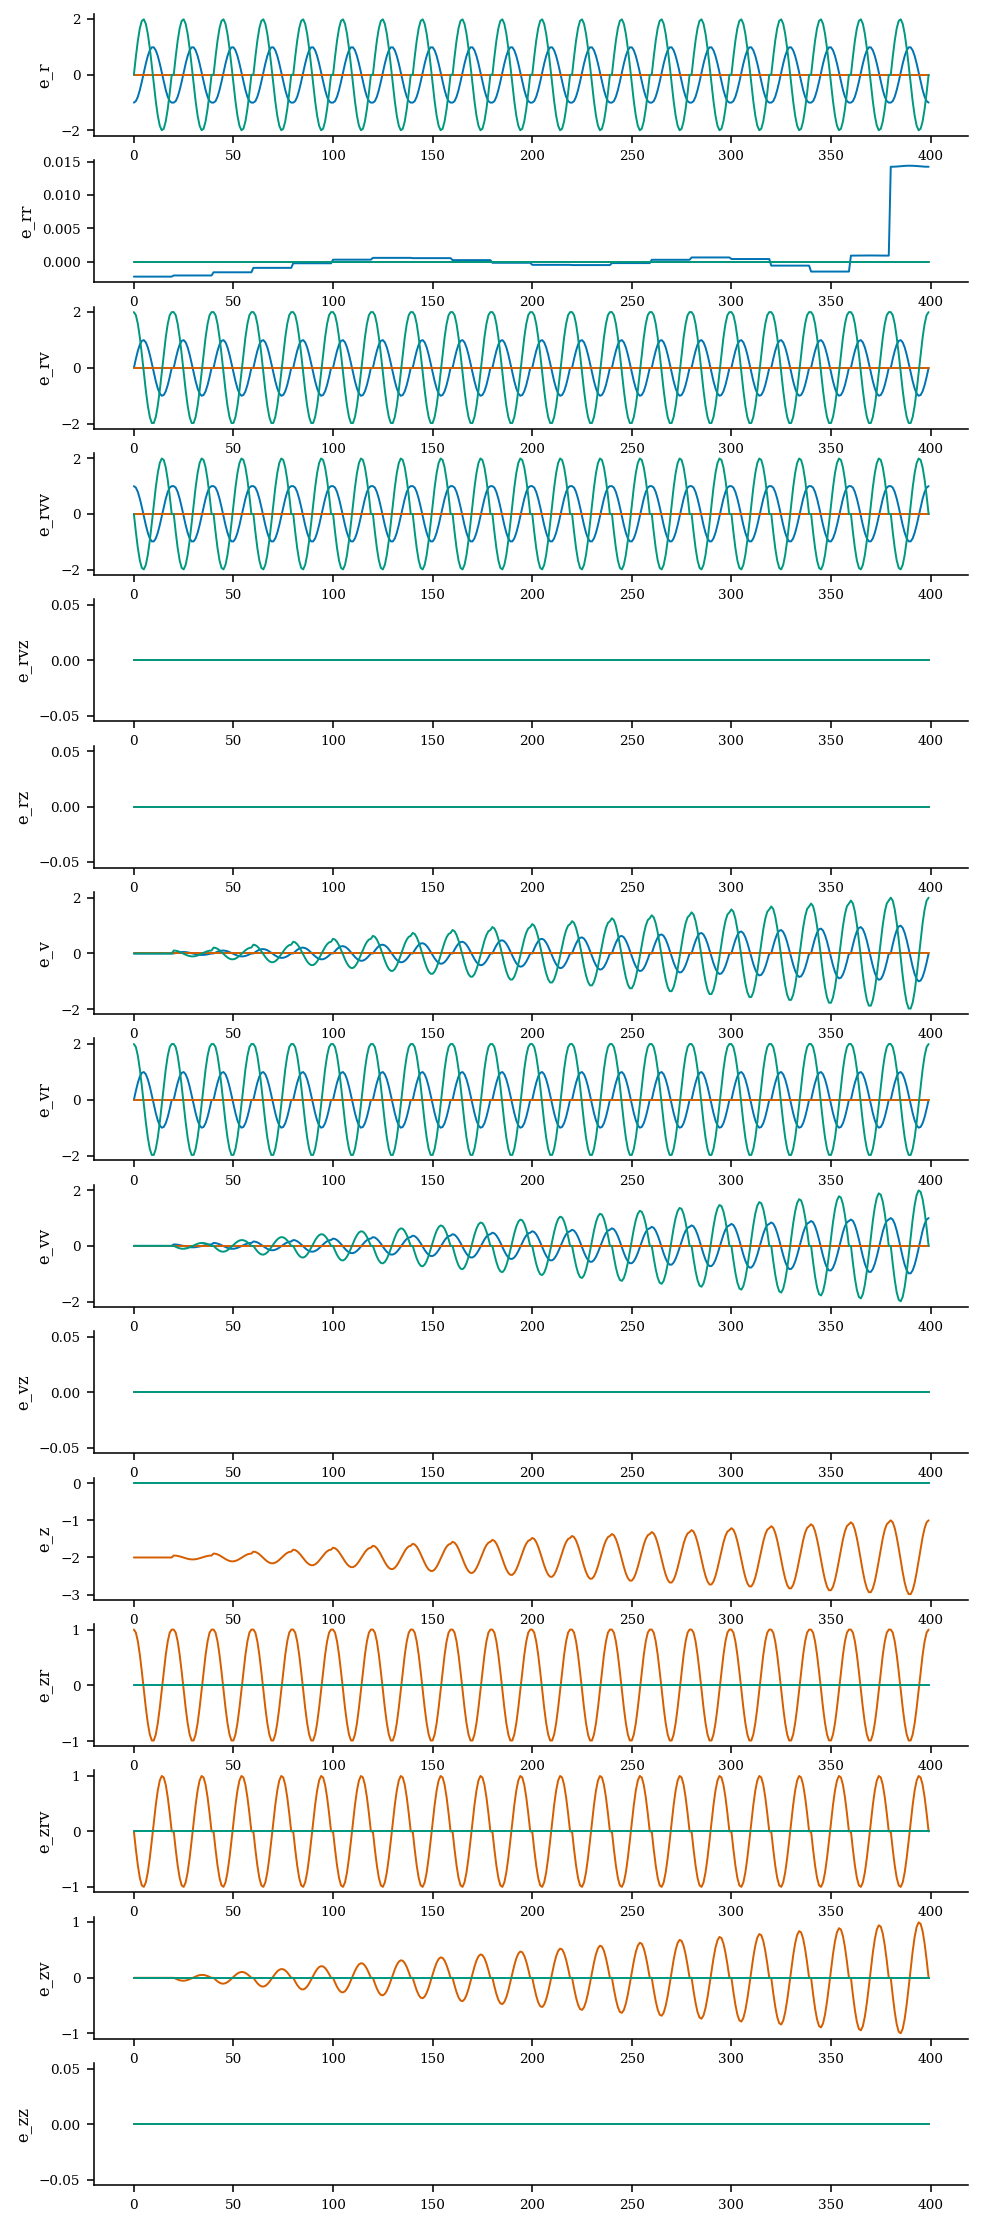

In [54]:
data = covariant_basis_vectors
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val,lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

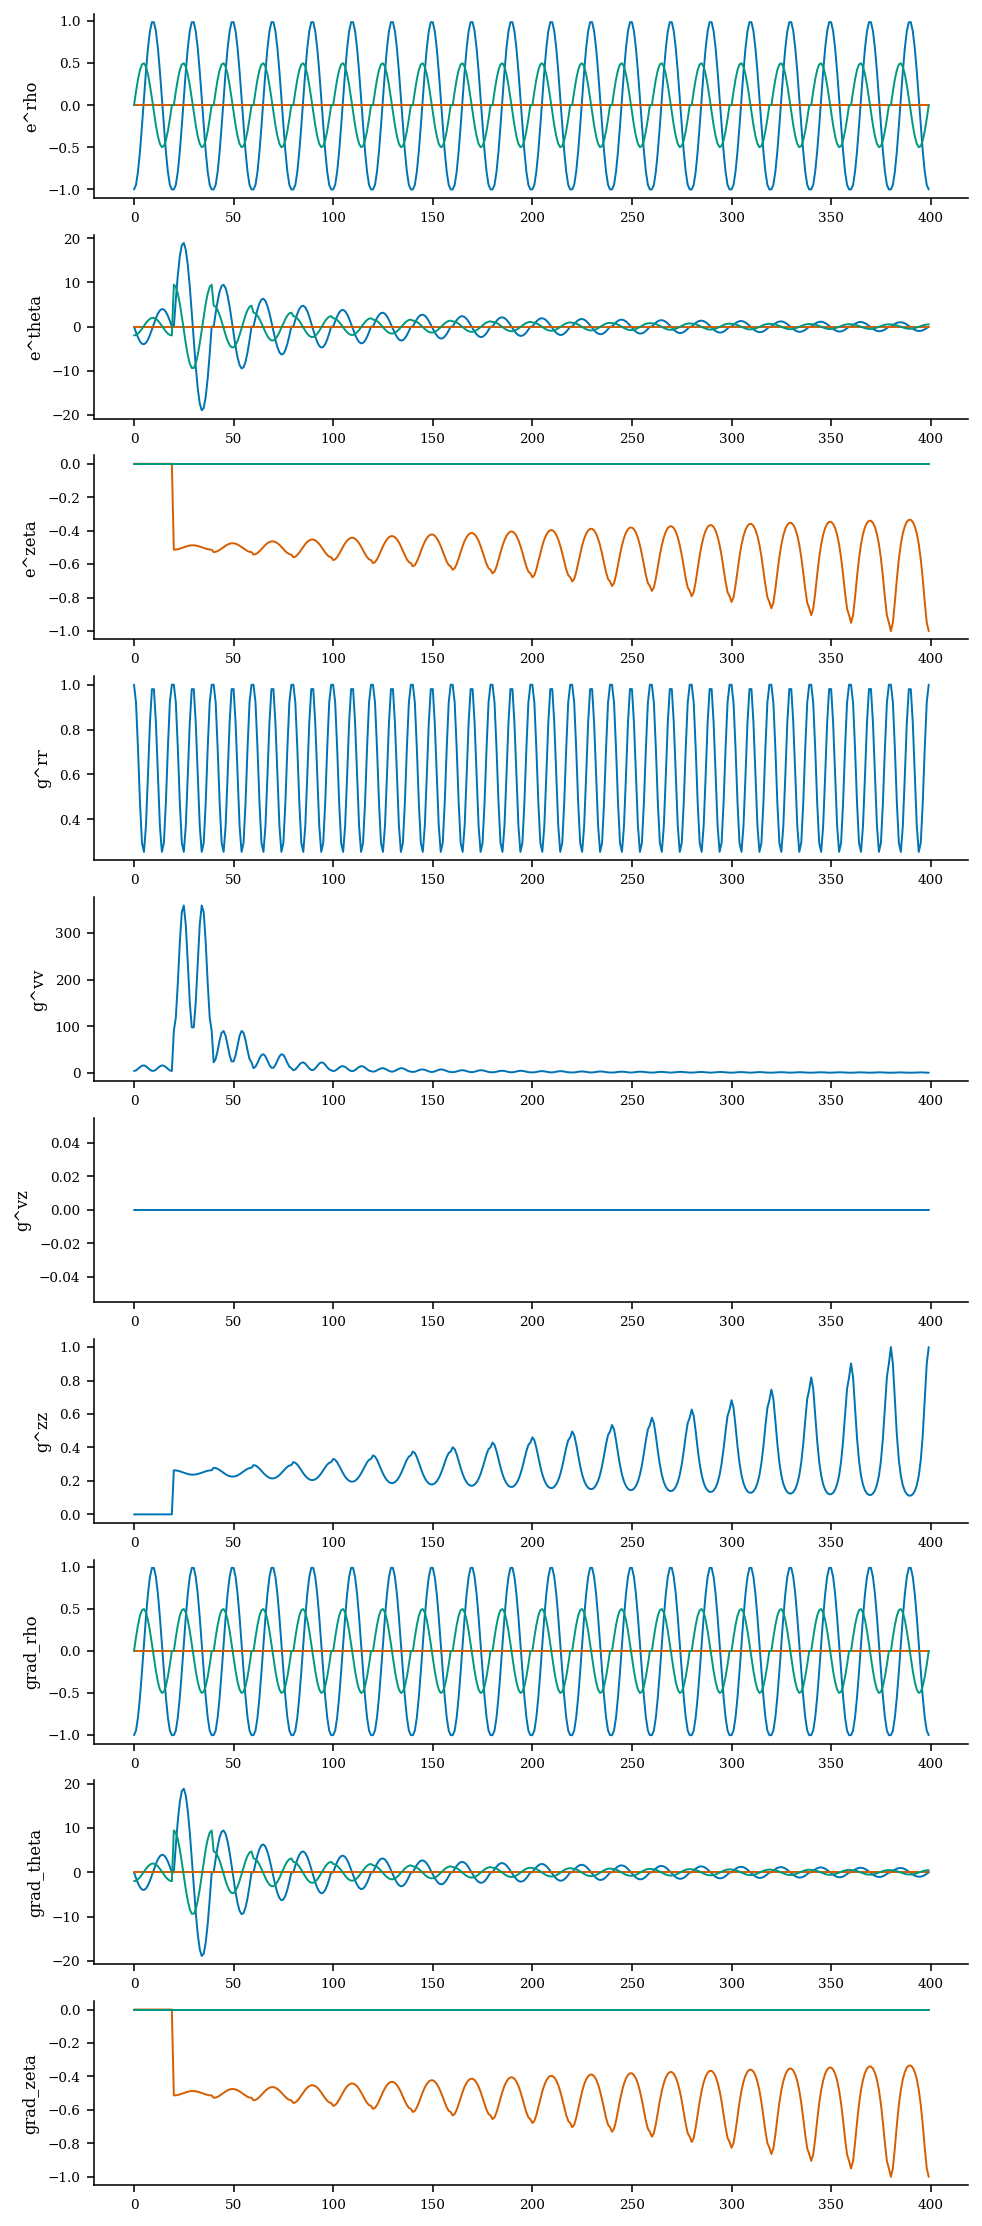

In [55]:
data = contravariant_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val,lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

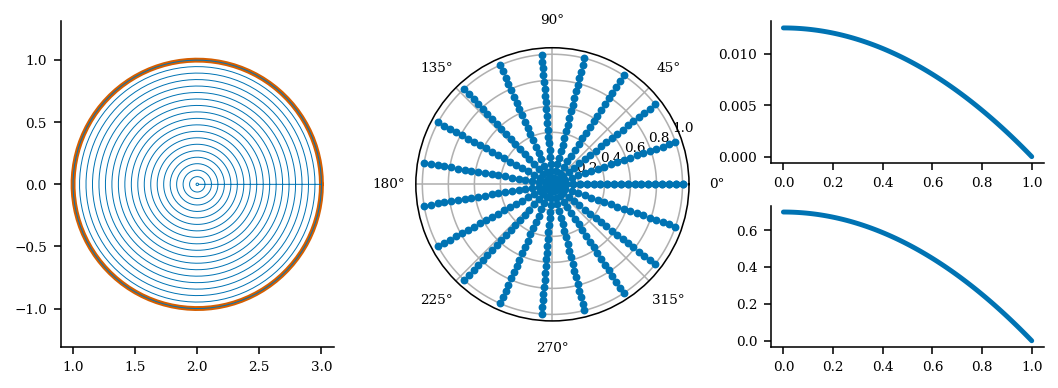

In [36]:

# Inputs
Psi_total = 1
M = 6
N = 0
NFP = 1

# Node locations
N_nodes = 100
r = np.linspace(0,1,20)
dr = np.diff(r)[0]
v = np.linspace(0,2*np.pi,20)
dv = np.diff(v)[0]
dz = 2*np.pi/NFP
rr,vv = np.meshgrid(r,v,indexing='ij')
rr = rr.flatten()
vv = vv.flatten()
zz = np.zeros_like(rr)
nodes = np.stack([rr,vv,zz])
dr = dr*np.ones_like(rr)
dv = dv*np.ones_like(vv)
dz = dz*np.ones_like(zz)
node_volume = np.stack([dr,dv,dz])
axn = np.where(rr == 0)[0]
# interpolator
zernt = ZernikeTransform(nodes,M,N,NFP)

# Boundary Shape
bdry_theta = np.linspace(0,2*np.pi,100)
bdry_phi = np.zeros_like(bdry_theta)
b = 1
a = 1
R0 = 2
Z0 = 0
bdryR = R0 + b*np.cos(bdry_theta)
bdryZ = Z0 + a*np.sin(bdry_theta)

# profiles
iotafun_params = ()
pressfun_params = ()


# initial guess
cR_init,cZ_init,cL_init, Rinit, Zinit = get_initial_guess_scale_bdry(bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP)
x_init = np.concatenate([cR_init,cZ_init,cL_init])

# weights
weights = {'F':1e4,     # force balance error
           'R':1e6,     # error in R component of bdry
           'Z':1e6,     # error in Z component of bdry
           'L':1e8}     # error in sum lambda_mn


args = (M,N,NFP,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume,bdryR,bdryZ,bdry_theta,bdry_phi,weights)


# plot IC
fig = plt.figure(figsize=(9,3))
gs = matplotlib.gridspec.GridSpec(2, 3) 
ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[:,1],projection='polar')
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[1,2])

ax0.plot(bdryR,bdryZ,color=colorblind_colors[1])
ax0.plot(Rinit,Zinit,lw=.5)
ax0.axis('equal');
ax1.plot(nodes[1],nodes[0],'o',markersize=3);
xx = np.linspace(0,1,100)
ax2.plot(xx,pressfun(xx))
ax3.plot(xx,iotafun(xx))
plt.subplots_adjust(wspace=0.3, hspace=0.3)


In [22]:
def lstsq_obj(x,M,N,NFP,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume,bdryR,bdryZ,bdry_theta,bdry_phi,weights):
    nRZ = (M+1)**2*(2*N+1)
    nL = (2*M+1)*(2*N+1)
    cR = x[:nRZ]
    cZ = x[nRZ:2*nRZ]
    cL = x[2*nRZ:]
    
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    errR,errZ,errL = compute_bc_err_RZ(cR,cZ,cL,bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP)

    # divide through by size of the array so weighting isn't thrown off by more points
    loss = np.concatenate([weights['F']*errF.flatten()/errF.size,   
                           weights['R']*errR.flatten()/errR.size,
                           weights['Z']*errZ.flatten()/errZ.size,
                           weights['L']*errL.flatten()/errL.size])
    return loss

def force_obj(x,M,N,NFP,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume,bdryR,bdryZ,bdry_theta,bdry_phi,weights):
    nRZ = (M+1)**2*(2*N+1)
    nL = (2*M+1)*(2*N+1)
    cR = x[:nRZ]
    cZ = x[nRZ:2*nRZ]
    cL = x[2*nRZ:]
    
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    return weights['F']*rms(errF)

def bc_constraint_fun(x,M,N,NFP,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume,bdryR,bdryZ,bdry_theta,bdry_phi,weights):
    nRZ = (M+1)**2*(2*N+1)
    nL = (2*M+1)*(2*N+1)
    cR = x[:nRZ]
    cZ = x[nRZ:2*nRZ]
    cL = x[2*nRZ:]
    
    errR,errZ,errL = compute_bc_err_RZ(cR,cZ,cL,bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP)
    return rms(errR) + rms(errZ)

def lambda_constraint_fun(x,M,N,NFP,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume,bdryR,bdryZ,bdry_theta,bdry_phi,weights):
    nRZ = (M+1)**2*(2*N+1)
    nL = (2*M+1)*(2*N+1)
    cR = x[:nRZ]
    cZ = x[nRZ:2*nRZ]
    cL = x[2*nRZ:]
    
    errR,errZ,errL = compute_bc_err_RZ(cR,cZ,cL,bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP)
    return errL

class FiniteDifferenceJacobian():
    def __init__(self, fun, rel_step=np.finfo(np.float64).eps**(1/3)):
        self.fun = fun
        self.rel_step = rel_step
    def __call__(self,x0,*args):
        f0 = self.fun(x0,*args)
        m = f0.size
        n = x0.size
        J_transposed = np.empty((n, m))
        idx = np.arange(m).astype(np.int64)
        sign_x0 = (x0 >= 0).astype(float) * 2 - 1
        h = self.rel_step * sign_x0 * np.maximum(1.0, np.abs(x0))
        h_vecs = np.diag(h)
        for i in range(h.size):
            x1 = x0 - h_vecs[i]
            x2 = x0 + h_vecs[i]
            dx = x2[i] - x1[i]
            f1 = self.fun(x1,*args)
            f2 = self.fun(x2,*args)
            df = f2 - f1
            dfdx = df / dx
            put(J_transposed,i*m+idx,dfdx)
        if m == 1:
            J_transposed = np.ravel(J_transposed)
        return J_transposed.T
    

def callback(x,f=None,convergence=None):
    nRZ = (M+1)**2*(2*N+1)
    nL = (2*M+1)*(2*N+1)
    cR = x[:nRZ]
    cZ = x[nRZ:2*nRZ]
    cL = x[2*nRZ:]
    
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    errR,errZ,errL = compute_bc_err_RZ(cR,cZ,cL,bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP)
    
    errFrms = rms(errF)
    errRrms = rms(errR)
    errZrms = rms(errZ)    
    errLrms = rms(errL)
    
    loss = np.concatenate([weights['F']*errF.flatten(),
                           weights['R']*errR.flatten(),
                           weights['Z']*errZ.flatten(),
                           weights['L']*errL.flatten()])
    lossrms = rms(loss)    
    print('Loss: {:10.3e}  errF: {:10.3e}  errR: {:10.3e}  errZ: {:10.3e}  errL: {:10.3e}'.format(
    lossrms,errFrms,errRrms,errZrms,errLrms))

In [23]:
force_obj = jit(force_obj, static_argnums=np.arange(1,15))
force_jac = jit(jax.jacfwd(force_obj),static_argnums=np.arange(1,15))

bc_constraint_fun = jit(bc_constraint_fun, static_argnums=np.arange(1,15))
bc_jac = jit(jax.jacfwd(bc_constraint_fun),static_argnums=np.arange(1,15))

lambda_constraint_fun = jit(lambda_constraint_fun, static_argnums=np.arange(1,15))
lambda_jac = jit(jax.jacfwd(lambda_constraint_fun),static_argnums=np.arange(1,15))

In [37]:
force_obj(x_init,*args).block_until_ready()
force_jac(x_init,*args).block_until_ready()
bc_constraint_fun(x_init,*args).block_until_ready()
bc_jac(x_init,*args).block_until_ready()
lambda_constraint_fun(x_init,*args).block_until_ready()
lambda_jac(x_init,*args).block_until_ready()

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)

In [26]:
lstsq_obj = jit(lstsq_obj, static_argnums=np.arange(1,15))
jac = jit(jax.jacfwd(lstsq_obj),static_argnums=np.arange(1,15))

In [31]:
fjac = FiniteDifferenceJacobian(lstsq_obj)
fjac = jit(fjac,static_argnums=np.arange(1,15))

In [32]:
foo = fjac(x_init,*args)

In [33]:
%%timeit
foo = fjac(x_init,*args)

1.9 s ± 81.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit
cost = lstsq_obj(x_init,*args).block_until_ready() 

542 µs ± 87.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
foo = jac(x_init,*args).block_until_ready() 

14.7 ms ± 908 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
callback(x_init)
out = scipy.optimize.least_squares(lstsq_obj,
                                   x_init,
                                   args=args,
                                   jac=jac if use_jax else None,
                                   x_scale='jac',
                                   ftol=1e-4, 
                                   xtol=1e-4, 
                                   gtol=1e-4, 
                                   max_nfev=200, 
                                   verbose=2)

Loss:  1.904e+02  errF:  2.334e-02  errR:  4.026e-07  errZ:  1.343e-15  errL:  0.000e+00
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.8080e+01                                    3.59e+04    
       1              5         2.2637e+01      4.54e+01       4.14e-02       3.33e+04    
       2              6         1.0028e+01      1.26e+01       8.01e-02       1.64e+05    
       3              8         1.0823e+00      8.95e+00       2.01e-02       5.44e+04    
       4             10         2.4961e-01      8.33e-01       9.95e-03       5.99e+03    
       5             11         1.9620e-01      5.34e-02       1.98e-02       1.52e+04    
       6             12         1.6561e-01      3.06e-02       1.97e-02       1.94e+04    
       7             13         4.6448e-02      1.19e-01       5.00e-03       1.33e+03    
       8             14         4.2530e-02      3.92e-03       1.00e-02       7.93e+03    
 

In [41]:
callback(x_init)
callback(out['x'])

Loss:  1.904e+02  errF:  2.334e-02  errR:  4.026e-07  errZ:  1.343e-15  errL:  0.000e+00
Loss:  5.350e-02  errF:  6.557e-06  errR:  1.098e-09  errZ:  8.541e-10  errL:  4.510e-20


In [34]:
callback(x_init)

slsqp_constraints=[{'type':'eq',
                    'fun':lambda_constraint_fun,
                    'jac':lambda_jac if use_jax else None,
                    'args': args},
                   {'type':'eq',
                    'fun':bc_constraint_fun,
                    'jac':bc_jac if use_jax else None,
                    'args': args}]

trf_constraints = [scipy.optimize.NonlinearConstraint(lambda x: bc_constraint_fun(x,*args), 
                                                      0, 
                                                      0, 
                                                      jac=lambda x: bc_jac(x,*args), 
                                                      keep_feasible=True, 
                                                      ),
                   scipy.optimize.NonlinearConstraint(lambda x: lambda_constraint_fun(x,*args), 
                                                      0, 
                                                      1e-6, 
                                                      jac=lambda x: lambda_jac(x,*args), 
                                                      keep_feasible=True, 
                                                      )
                  ]

out = scipy.optimize.minimize(force_obj,
                              x_init,
                              args=args,
                              method='SLSQP',
                              jac=force_jac if use_jax else None,
                              options={'disp':True,
                                       'maxiter':500},
                              constraints=slsqp_constraints,
                              callback=callback
                             )

# out = scipy.optimize.minimize(force_obj,
#                               x_init,
#                               args=args,
#                               method='trust-constr',
#                               jac=force_jac if use_jax else None,
#                               options={'disp':True,
#                                        'maxiter':500},
#                               constraints=trf_constraints,
#                               callback=callback
#                              )

Loss:  1.913e+02  errF:  2.345e-02  errR:  4.026e-07  errZ:  2.687e-15  errL:  0.000e+00
Loss:  1.346e+16  errF:  1.649e+12  errR:  2.627e+04  errZ:  4.267e+04  errL:  1.705e-13
Loss:  5.065e+14  errF:  6.208e+10  errR:  7.350e+03  errZ:  6.337e+03  errL:  1.705e-12
Loss:  3.176e+14  errF:  3.893e+10  errR:  8.287e+03  errZ:  8.027e+03  errL:  1.137e-13
Loss:  9.923e+13  errF:  1.216e+10  errR:  5.644e+03  errZ:  8.328e+03  errL:  2.842e-13
Loss:  6.680e+13  errF:  8.189e+09  errR:  4.247e+03  errZ:  3.662e+03  errL:  5.116e-13
Loss:  3.327e+13  errF:  4.079e+09  errR:  3.311e+03  errZ:  3.880e+03  errL:  3.286e-13
Loss:  3.274e+13  errF:  4.013e+09  errR:  4.588e+03  errZ:  4.015e+03  errL:  1.648e-12
Loss:  4.543e+14  errF:  5.569e+10  errR:  9.102e+03  errZ:  7.258e+03  errL:  1.705e-12
Loss:  1.172e+14  errF:  1.437e+10  errR:  5.632e+03  errZ:  5.789e+03  errL:  2.956e-12
Loss:  1.134e+13  errF:  1.390e+09  errR:  2.238e+03  errZ:  3.045e+03  errL:  0.000e+00
Loss:  1.495e+13  err

[1.80320102] [-0.00890099]


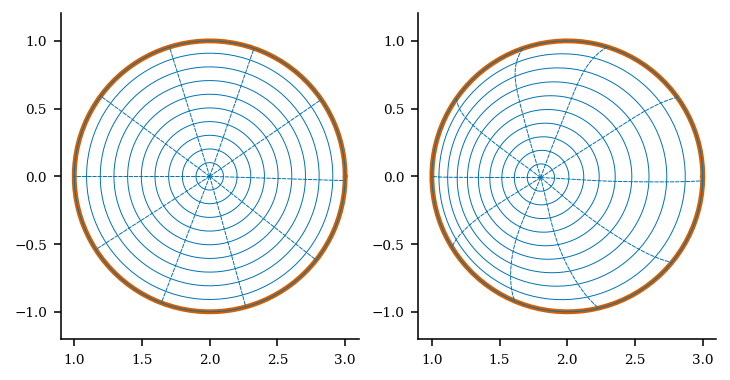

In [42]:
x = out['x']
nRZ = (M+1)**2*(2*N+1)
nL = (2*M+1)*(2*N+1)
cR = x[:nRZ]
cZ = x[nRZ:2*nRZ]
cL = x[2*nRZ:]

R0 = np.unique(zernt.transform(cR,0,0,0)[np.where(zernt.nodes[0]==0)[0]])
Z0 = np.unique(zernt.transform(cZ,0,0,0)[np.where(zernt.nodes[0]==0)[0]])
print(R0,Z0)

fig, ax = plt.subplots(1,2,figsize=(6,3))
plotter(cR_init,cZ_init,M,N,NFP,ax=ax[0],nr=10,ntheta=10)
plotter(cR,cZ,M,N,NFP,ax=ax[1],nr=10,ntheta=10)

In [93]:
def DESC_to_gfile(cR,cZ,iotafun,pressfun,Psi_total,M,N,NFP,nw=65,nh=65,nr=50,ntheta=50,npsi=1000, 
                  rdim=None,zdim=None,rleft=None,rcentr=None,zmid=None,axis_flux=0):

    g = {}
    g['date']=pytime.localtime()
    g['shot']=0
    g['time']=0
    g['efit']='DESC'
    g['nw']=nw
    g['nh']=nh


    # get poloidal flux (psi) as function of toroidal flux (rho)
    efitPsi = np.linspace(0,1,g['nw'])
    rho_n = np.linspace(1e-3,1,npsi)
    rho = 2*Psi_total*rho_n
    iota = iotafun(rho_n)
    psi = scipy.integrate.cumtrapz(rho*iota,rho_n,initial=axis_flux)
    psi_n = (psi - np.min(psi))/(np.max(psi)-np.min(psi))
    psi_n_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi_n)
    psi_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi)
    rho_n_of_psi_n = scipy.interpolate.CubicSpline(psi_n,rho_n)

    # get Bt
    vv = np.zeros_like(rho_n)
    zz = np.zeros_like(rho_n)
    nodes = np.stack([rho_n,vv,zz])
    zernt = ZernikeTransform(nodes,M,N,NFP)
    coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
    covariant_basis_vectors = compute_covariant_basis_vectors(coordinate_derivatives)
    jacobian = compute_jacobian(coordinate_derivatives,covariant_basis_vectors)
    B_field = compute_B_field(Psi_total, jacobian, nodes, covariant_basis_vectors, iotafun)
    R = zernt.transform(cR).flatten()
    B = B_field['B^theta']*covariant_basis_vectors['e_v'] + B_field['B^zeta']*covariant_basis_vectors['e_z']
    Bt = B[1]
    g['bcentr'] = np.linalg.norm(B[:,0])

    # compute profiles
    Fpol = scipy.interpolate.CubicSpline(rho_n,R*Bt)
    g['fpol'] = Fpol(rho_n_of_psi_n(efitPsi))
    g['ffprime'] = Fpol(rho_n_of_psi_n(efitPsi))*Fpol(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    g['pres'] = pressfun(rho_n_of_psi_n(efitPsi))
    g['pprime'] = pressfun(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    iotapsi = iotafun(rho_n_of_psi_n(efitPsi))
    qidx = np.where(iotapsi != 0)[0]
    g['qpsi'] = scipy.interpolate.CubicSpline(efitPsi[qidx],1/iotapsi[qidx])(efitPsi)


    # compute psi(R,Z)
    r = np.linspace(0,1,nr)
    v = np.linspace(0,2*np.pi,ntheta)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    rr = rr.flatten()
    vv = vv.flatten()
    zz = np.zeros_like(rr)
    nodes = np.stack([rr,vv,zz])
    axn = np.where(rr==0)[0]
    bdryn = np.where(rr==1)[0]
    zernt = ZernikeTransform(nodes,M,N,NFP)

    R = zernt.transform(cR).flatten()
    Z = zernt.transform(cZ).flatten()
    psiRZ = psi_of_rho_n(rr)

    g['rmaxis'] = np.mean(R[axn])
    g['zmaxis'] = np.mean(Z[axn])
    g['nbbbs'] = bdryn.size
    g['rbbbs'] = R[bdryn]
    g['zbbbs'] = Z[bdryn]
    g['axis_flux'] = np.mean(psiRZ[axn])
    g['boundary_flux'] = np.mean(psiRZ[bdryn])

    g['rdim'] = rdim if rdim else (np.max(R)-np.min(R))*1.5
    g['rcentr'] = rcentr if rcentr else (np.max(R)+np.min(R))/2
    g['zdim'] = zdim if zdim else (np.max(Z)-np.min(Z))*1.5
    g['zmid'] = zmid if zmid else (np.max(Z)+np.min(Z))/2
    g['rleft'] = rleft if rleft else g['rcentr'] - g['rdim']/2

    efitR = np.linspace(g['rleft'],g['rleft']+g['rdim'],g['nw'])
    efitZ = np.linspace(-g['zdim']/2,g['zdim']/2,g['nh'])
    efitRR,efitZZ = np.meshgrid(efitR,efitZ,indexing='ij')

    g['psirz'] = scipy.interpolate.griddata((R,Z),psiRZ,(efitRR,efitZZ),method='cubic').T
    g['psirz'][np.isnan(g['psirz'])] = g['boundary_flux']

    g['limitr'] = 0
    g['rlimitr'] = np.array([])
    g['zlimitr'] = np.array([])
    
    return g

(<Figure size 1128x846 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d90c86ac8>,
       dtype=object))

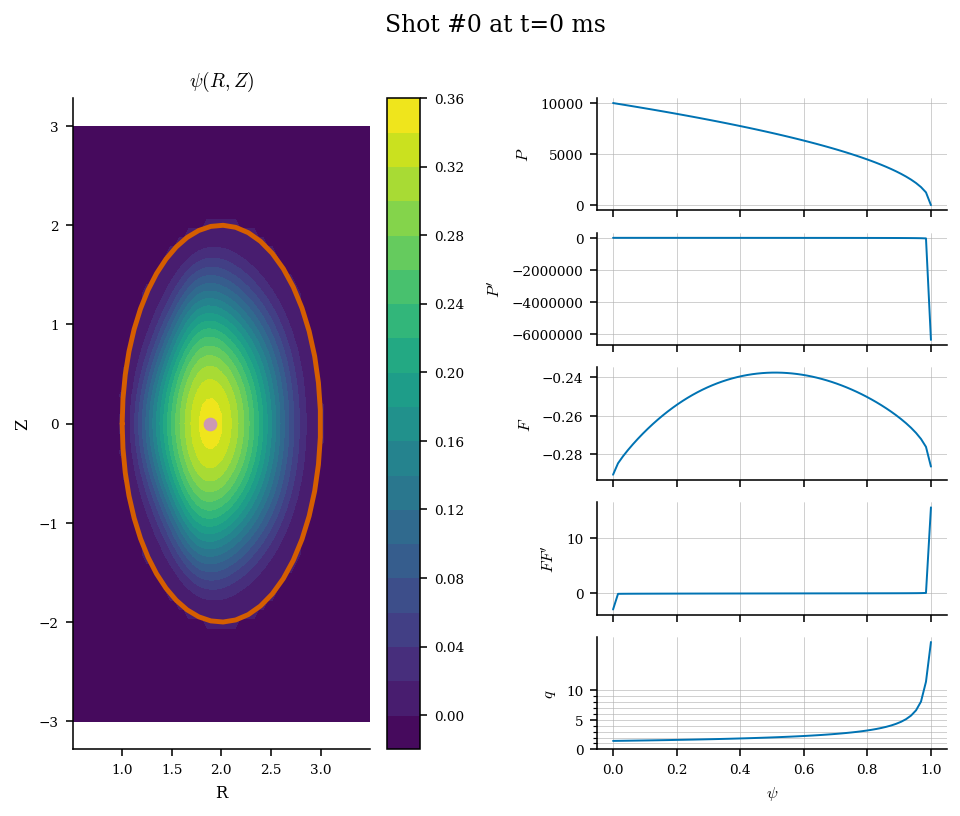

In [92]:
plot_gfile(DESC_to_gfile(cR,cZ,iotafun,pressfun,Psi_total,M,N,NFP))

In [ ]:
Rfoo = ['R','R_r','R_v','R_z','R_rr','R_rv','R_vv','R_zr','R_zv','R_zz','R_rrv','R_rvv','R_zrv','R_rrvv'];
Rfoo = ['Z','Z_r','Z_v','Z_z','Z_rr','Z_rv','Z_vv','Z_zr','Z_zv','Z_zz','Z_rrv','Z_rvv','Z_zrv','Z_rrvv'];


fig, ax = plt.subplots(len(Rfoo), figsize=(6,12))
for i, foo in enumerate(Rfoo):
    ax[i].plot(coordinate_derivatives[foo],lw=1)
    ax[i].set_ylabel(foo)

In [ ]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(1,3, figsize=(8,2))

im0 = ax[0].tricontourf(nodes[0],nodes[1],F_err[0], levels=30)
ax[0].set_title('$F_R$')
ax[0].set_xlabel('$\\rho$')
ax[0].set_ylabel('$\\vartheta$')
# ax[0].set_xticks(np.linspace(0,1e-3,3))
# ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[0].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[0].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im0, ax=ax[0], orientation='vertical',fraction=.1)

im1 = ax[1].tricontourf(nodes[0],nodes[1],F_err[1], levels=30)
ax[1].set_title('$F_\\phi$')
ax[1].set_xlabel('$\\rho$')
ax[1].set_ylabel('$\\vartheta$')
# ax[1].set_xticks(np.linspace(0,1e-3,3))
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[1].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[1].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im1, ax=ax[1], orientation='vertical',fraction=.1)

im2 = ax[2].tricontourf(nodes[0],nodes[1],F_err[2], levels=30)
ax[2].set_title('$F_Z$')
ax[2].set_xlabel('$\\rho$')
ax[2].set_ylabel('$\\vartheta$')
# ax[2].set_xticks(np.linspace(0,1e-3,3))
# ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[2].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[2].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im2, ax=ax[2], orientation='vertical',fraction=.1)
# plt.axis('equal')
# plt.colorbar()
plt.subplots_adjust(wspace=.5)

In [ ]:
axn = np.where(nodes[0]==0)[0]
fig, ax = plt.subplots(1,4, figsize=(8,3))

ax[0].plot(nodes[1,axn],F_err[0,axn],lw=1)
ax[0].set_title('$F_R$')
ax[0].set_xlabel('$\\vartheta$')
ax[0].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[0].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[1].plot(nodes[1,axn],F_err[1,axn],lw=1)
ax[1].set_title('$F_\\phi$')
ax[1].set_xlabel('$\\vartheta$')
ax[1].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[1].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[2].plot(nodes[1,axn],F_err[2,axn],lw=1)
ax[2].set_title('$F_Z$')
ax[2].set_xlabel('$\\vartheta$')
ax[2].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[2].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[3].plot(nodes[1,axn],np.linalg.norm(F_err[:,axn],axis=0),lw=1)
ax[3].set_title('$||F||$')
ax[3].set_xlabel('$\\vartheta$')
ax[3].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[3].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$']);


In [ ]:
logerr = np.sign(F_err)*np.log(np.abs(F_err))
plt.quiver(R,Z,logerr[0],logerr[2],headwidth=3,headlength=5,width=2e-3)
plt.plot(bdryR,bdryZ)
plt.scatter(R,Z,s=3)
plt.axis('equal');

In [74]:
from sympy import symbols, Matrix, diff, pi

er_R, er_P, er_Z = symbols("R_rho phi_rho Z_rho")
ev_R, ev_P, ev_Z = symbols("R_theta phi_theta Z_theta")
ez_R, ez_P, ez_Z = symbols("R_\zeta R Z_\zeta")
psi_a, rho, iota = symbols("psi_a rho iota")

psi = psi_a*rho**2
e_r = Matrix([er_R,0,er_Z])
e_v = Matrix([ev_R,0,ev_Z])
e_z = Matrix([ez_R,ez_P,ez_Z])

g = e_v.cross(e_z).dot(e_r)

erho = e_v.cross(e_z)/g
etheta = e_z.cross(e_r)
ezeta = e_r.cross(e_v)

Bzeta = diff(psi,rho)/(2*pi*g)
Btheta = iota*Bzeta
B = Btheta*etheta + Bzeta*ezeta


beta = Bzeta*etheta - Btheta*ezeta

In [72]:
erho

Matrix([
[                         -R*Z_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[(R_\zeta*Z_theta - R_theta*Z_\zeta)/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[                          R*R_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)]])

In [73]:
beta

Matrix([
[                                                                                                                      R*Z_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[-iota*psi_a*rho*(-R_rho*Z_theta + R_theta*Z_rho)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho)) + psi_a*rho*(-R_\zeta*Z_rho + R_rho*Z_\zeta)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[                                                                                                                     -R*R_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))]])

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t}  \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
1 & 0 \\
\frac{\partial \phi}{\partial R} & \frac{\partial \phi}{\partial Z} \\
0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\vartheta = \pi - \theta + \lambda(\theta,\phi)
$$